### Pipeline Structure

1. Retrieve Data
    - Find letter images and retrieve them
    
2. Data Augmentation
   - Contour the images 
   - Increase the brightness
    <br></br>
3. CNN Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import string

import torch
import torch.nn as nn

from torch.optim import RMSprop
from torch.optim import SGD

from torch.utils.data import DataLoader, Dataset

from torchinfo import summary

from torchvision.io import read_image
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
# from torchmetrics import Accuracy

C:\Users\Brand\AppData\Local\Temp\ipykernel_2448\53237925.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data_path = Path(r"C:\Users\Brand\project_env\PyTorch-Fundamentals\Convolutional-Neural-Network\data\Letter Data")
letter_data_path = data_path / "A_Z Handwritten Data.csv"

letter_data = pd.read_csv(letter_data_path)

In [3]:
len(letter_data)

372450

In [4]:
y = letter_data["0"]
X = letter_data.drop(columns=["0"]) 

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, test_size=0.4, random_state=42)

In [5]:
len(y_test.unique())

26

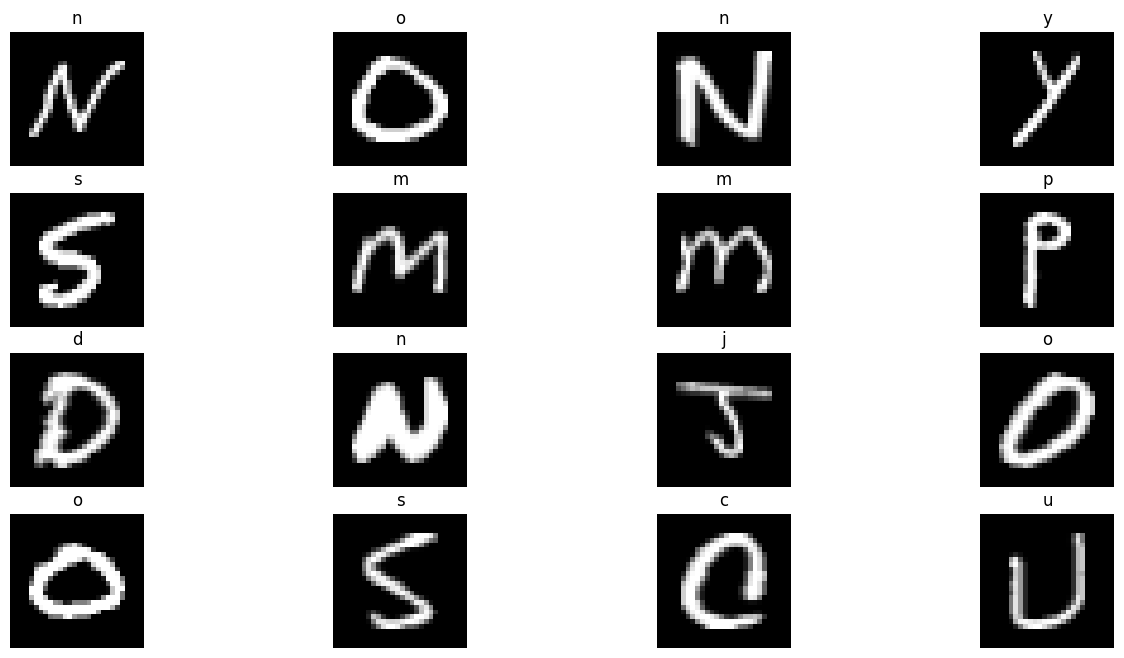

In [6]:
def viz_image(images, images_labels, seed=42, plot_dim=(4,4)):
    height, width = plot_dim
    fig, ax = plt.subplots(height, width, figsize=(16,8))
    
    np.random.seed(seed)
    alphabets = {i: string.ascii_lowercase[i] for i in range(0, 26)}

    for i in range(height):
        for j in range(width):
            m,_ = X.shape
            random_num = np.random.randint(0, m)

            img = images.iloc[random_num].to_numpy().reshape(28, 28)
            img_label = images_labels.iloc[random_num]

            ax[i, j].set_title(alphabets[img_label])
            ax[i, j].imshow(img, cmap="gray")
            ax[i, j].axis(False)

viz_image(X, y)

In [7]:
transform_params = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485],
                         std=[0.229])
])

In [8]:
class Letter_Dataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None):
        self.df = torch.tensor(X.to_numpy().reshape(len(X), 1,28,28)).to(torch.float32)
        
        self.df_labels = y
        self.labels = self.df_labels.to_numpy()
        
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, i):
        if self.transform:
            self.transform(self.df)
            
        return self.df[i], self.labels[i]

In [9]:
m, _ = letter_data.shape
threshold = 0.6


train_data, test_data = letter_data[0: int(m * 0.6)], letter_data[int(m * 0.6): m]

digit_train_data = Letter_Dataset(X_train, y_train)
digit_test_data = Letter_Dataset(X_test, y_test)

train_dataloader = DataLoader(digit_train_data, batch_size=8, shuffle=True, drop_last=True)
test_dataloader = DataLoader(digit_test_data, batch_size=8, shuffle=False, drop_last=True)

train_feature, train_label = next(iter(train_dataloader))
train_feature

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [10]:
class Letter_Classification_Model(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        
        self.conv_block_0 = nn.Sequential(
            nn.Conv2d(input_channels, 
                      out_channels=6, 
                      kernel_size=5),
            
            nn.AvgPool2d(kernel_size=2, 
                         stride=2),
            
            nn.BatchNorm2d(6),
            nn.ReLU() 
        )
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=6, 
                      out_channels=16,
                      kernel_size=5),
            
            nn.AvgPool2d(kernel_size=2,
                         stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU() 
        )
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 120),
            nn.Linear(120, 84),
            nn.Linear(84, output_channels)
        )
    
    def forward(self, x):
        x = self.conv_block_0(x)
        x = self.conv_block_1(x)
        x = self.fc(x)
        
        return x

In [11]:
letter_model = Letter_Classification_Model(1, 26)

print(torch.sum(letter_model.forward(train_feature).argmax(dim=1) == train_label).numpy() / 8)
train_label

0.0


tensor([19, 13, 14, 20,  0, 10, 14, 18])

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
letter_model.to(device)

Letter_Classification_Model(
  (conv_block_0): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv_block_1): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=256, out_features=120, bias=True)
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): Linear(in_features=84, out_features=26, bias=True)
  )
)

In [13]:
# accuracy = Accuracy(task="multiclass", num_classes=26)
optimizer = SGD(letter_model.parameters(), lr=0.1)
cross_entropy_loss = nn.CrossEntropyLoss()

In [14]:
summary(model=letter_model,
        input_size=(64, 1, 28, 28),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
Letter_Classification_Model (Letter_Classification_Model)    [64, 1, 28, 28] [64, 26]        --              True
├─Sequential (conv_block_0)                                  [64, 1, 28, 28] [64, 6, 12, 12] --              True
│    └─Conv2d (0)                                            [64, 1, 28, 28] [64, 6, 24, 24] 156             True
│    └─AvgPool2d (1)                                         [64, 6, 24, 24] [64, 6, 12, 12] --              --
│    └─BatchNorm2d (2)                                       [64, 6, 12, 12] [64, 6, 12, 12] 12              True
│    └─ReLU (3)                                              [64, 6, 12, 12] [64, 6, 12, 12] --              --
├─Sequential (conv_block_1)                                  [64, 6, 12, 12] [64, 16, 4, 4]  --              True
│    └─Conv2d (0)                                            [64, 6, 12, 12] [64, 16, 8

In [15]:
from tqdm.auto import tqdm



def train_test_process(model,
                       train_dataloader: DataLoader, 
                       test_dataloader: DataLoader, 
                       optimizer, 
                       loss_fn, 
                       epochs: int):
    
    # sets the model to train mode
    model.train()
    for epoch in tqdm(range(epochs)):

        print(f"Epoch: {epoch}\n-------")
        train_loss = 0
        for batch, (X,y) in enumerate(train_dataloader):
            X = X.to(device)
            y = y.to(device)
            # forward propogation, gets the predicted y value
            y_pred = model(X)

            # calculates the loss using cross entropy
            loss = loss_fn(y_pred, y)
            train_loss += loss

            # zeros the the gradients from before
            optimizer.zero_grad()

            # goes on to the next 
            loss.backward()
            optimizer.step()
            
            

                # Print out how many samples have been seen
            if batch % 4000 == 0:
                print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
        
        train_loss /= len(train_dataloader)

        # sets the model to evaluation mode
        model.eval()
        test_accuracy, test_loss = 0,0

        with torch.inference_mode():
            for X,y in test_dataloader:
                X = X.to(device)
                y = y.to(device)
                
                y_pred = model(X)
                
                test_loss += loss_fn(y_pred, y)
                test_accuracy += torch.sum(y_pred.cpu().detach().argmax(dim=1) == y.cpu().detach()).numpy() / 8

            test_loss /= len(test_dataloader)
            test_accuracy /= len(test_dataloader)

        print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_accuracy * 100:.2f}%\n")

In [16]:
train_test_process(model=letter_model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  optimizer=optimizer,
                  loss_fn=cross_entropy_loss,
                  epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/223470 samples
Looked at 32000/223470 samples
Looked at 64000/223470 samples
Looked at 96000/223470 samples
Looked at 128000/223470 samples
Looked at 160000/223470 samples
Looked at 192000/223470 samples

Train loss: 0.48482 | Test loss: 0.21059, Test acc: 93.76%

Epoch: 1
-------
Looked at 0/223470 samples
Looked at 32000/223470 samples
Looked at 64000/223470 samples
Looked at 96000/223470 samples
Looked at 128000/223470 samples
Looked at 160000/223470 samples
Looked at 192000/223470 samples

Train loss: 0.20972 | Test loss: 0.18307, Test acc: 94.77%

Epoch: 2
-------
Looked at 0/223470 samples
Looked at 32000/223470 samples
Looked at 64000/223470 samples
Looked at 96000/223470 samples
Looked at 128000/223470 samples
Looked at 160000/223470 samples
Looked at 192000/223470 samples

Train loss: 0.19580 | Test loss: 0.14036, Test acc: 96.17%

Epoch: 3
-------
Looked at 0/223470 samples
Looked at 32000/223470 samples
Looked at 64000/223470 samples
Looked at 96